全部特征直接放入，不对特征进行选择

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, sys, shutil
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, CatBoostClassifier
from typing import Tuple
from utility import *
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv('../preprocessed/combined_features_256.csv')
test  = pd.read_csv('../preprocessed/combined_features_256_test.csv')
train = shuffle(train, random_state=42)
y_train = train['label']
x_train = train.drop('label', axis=1)
Y_test = test['label']
X_test = test.drop('label', axis=1)

In [6]:
# xgboost
# 'booster': 'dart', 'lambda': 0.001642503154410547, 'alpha': 2.8456229527881028e-08, 'subsample': 0.3431387440085293, 'colsample_bytree': 0.5217278257570154, 
# 'learning_rate': 0.026933381156000847, 'n_estimators': 815, 'max_depth': 14, 'eta': 0.06455751355230073, 'gamma': 0.06478402966069816, 'grow_policy': 'depthwise', 
# 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0795037051330119e-05, 'skip_drop': 3.654340342849924e-05
xgb_c = xgb.XGBClassifier(eval_metric='logloss')
xgb_c.fit(x_train, y_train)
xgb_pred = xgb_c.predict(X_test)
xgb_accuracy = accuracy_score(xgb_pred, Y_test)
# xgb_pred
xgb_accuracy


0.96375

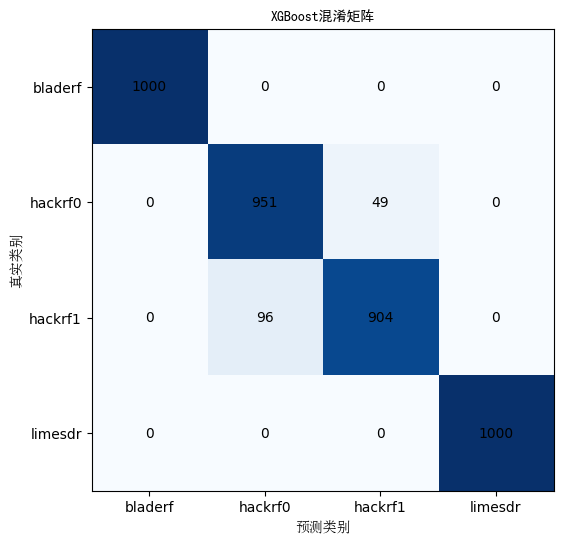

In [8]:
# 计算混淆矩阵
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, xgb_pred)
# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
for i in range(len(conf_mat)):
    for j in range(len(conf_mat)):
        plt.annotate(conf_mat[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')

plt.title('XGBoost混淆矩阵', fontproperties="SimHei")
plt.ylabel('真实类别', fontproperties="SimSun")
plt.xlabel('预测类别', fontproperties="SimSun")
plt.xticks(range(4), ['bladerf', 'hackrf0', 'hackrf1', 'limesdr'])
plt.yticks(range(4), ['bladerf', 'hackrf0', 'hackrf1', 'limesdr'])
# plt.colorbar()
plt.show()

In [5]:
# lightgbm
lgb_c = lgb.LGBMClassifier(verbose=0, force_row_wise=True)
lgb_c.fit(x_train, y_train)
lgb_pred = lgb_c.predict(X_test)
# y_pred = lgb_c.predict_proba(X_test)
lgb_accuracy = accuracy_score(lgb_pred, Y_test)
lgb_accuracy

0.961

In [6]:
# catboost
cat = CatBoostClassifier(verbose=0)
cat.fit(x_train, y_train)
cat_pred = cat.predict(X_test)
# cat_pred_proba = cat.predict_proba(X_test)
cat_accuracy = accuracy_score(cat_pred, Y_test)

cat_accuracy

0.9645

In [11]:
# gbdt
gbdt = GradientBoostingClassifier()
gbdt.fit(x_train, y_train)
gbdt_pred = gbdt.predict(X_test)

accuracy_score(gbdt_pred, Y_test)

0.94925

In [13]:
# dt
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt_pred = dt.predict(X_test)

accuracy_score(dt_pred, Y_test)

0.9175

In [15]:
# rg
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(X_test)

accuracy_score(rf_pred, Y_test)

0.95975

In [7]:
# svm
# from sklearn.model_selection import train_test_split, cross_val_score, KFold
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(kernel="linear", decision_function_shape="ovo", max_iter=100000, probability=True)
# train_scores = cross_val_score(svm, x_train, y_train, cv=kf, scoring='accuracy')
# print(np.mean(train_scores))
# {'kernel': 'rbf', 'C': 1472132.7090873513, 'gamma': 'scale'}
# svm = SVC(kernel='rbf', C=1472.1327090873513, gamma='scale', max_iter=100000)

svm.fit(x_train, y_train)
y_pred = svm.predict(X_test)
accuracy_score(y_pred, Y_test)

0.61075

In [8]:
# knn
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=10, p=1, n_jobs=-1)
knn.fit(x_train,y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_pred, Y_test)

0.5385

In [9]:
# bayes
bayes = GaussianNB()
bayes.fit(x_train,y_train)
y_pred = bayes.predict(X_test)
accuracy_score(y_pred, Y_test)

0.716

In [21]:

mul_estimators = [('xgb', xgb_c), ('lgb', lgb_c), ('cat', cat), ('svm', svm), ('knn', knn), ('bayes', bayes), ('rf', rf), ('dt', dt), ('gbdt', gbdt)]
mul_estimators = [('xgb', xgb_c), ('svm', svm), ('knn', knn), ('bayes', bayes), ('rf', rf), ('dt', dt)]
voting_clf_s = VotingClassifier(estimators=mul_estimators, voting='soft', n_jobs=-1)
voting_clf_s.fit(x_train, y_train)
softpred = voting_clf_s.predict(X_test)
soft_accuracy = accuracy_score(softpred, Y_test)

print(soft_accuracy)

0.948


In [17]:
lr = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42)

In [23]:
mul_estimators = [('xgb', xgb_c), ('svm', svm), ('knn', knn), ('bayes', bayes), ('dt', dt)]
stacking_clf = StackingClassifier(estimators=mul_estimators, final_estimator=lr, n_jobs=-1)
stacking_clf.fit(x_train, y_train)
stacking_clf_pred = stacking_clf.predict(X_test)
print('acc:', accuracy_score(Y_test, stacking_clf_pred))

acc: 0.9645
